In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# 스포티파이 API를 이용한 데이터 수집

df = pd.read_csv('audio_feature.csv')
df

,danceability,energy,music_key,loudness,music_mode,speechiness,acousticness,insrumentalness,liveness,valence,tempo,duration_ms,time_signature,TRACK_ID
0,0.620,0.586,1,-6.612,1,0.2120,0.1550,0.000000,0.5350,0.487,137.131,130980,4,000TJlEJQ3nafsm1hBWpoj
1,0.579,0.761,0,-5.550,1,0.0516,0.0975,0.001820,0.2730,0.286,126.163,148095,4,001op3H5t7sehq5JCG2PvM
2,0.585,0.683,8,-3.827,1,0.0523,0.7370,0.000000,0.1140,0.493,128.018,157987,3,002wiS64p2qXaYYVAP7KOW
3,0.557,0.845,5,-9.292,0,0.0466,0.2690,0.859000,0.1300,0.799,111.562,128090,4,003DYiYPxYSgbtRTXzkcf6
4,0.611,0.399,11,-11.474,0,0.0357,0.7220,0.000164,0.2590,0.310,122.880,296267,3,003iZmWziYecRnqwchpdQf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56890,0.651,0.720,9,-6.529,1,0.1610,0.3310,0.413000,0.5280,0.705,90.024,269245,4,7zy7iE31dGO70ShMXghsfj
56891,0.780,0.858,7,-6.331,0,0.1280,0.3570,0.000000,0.0937,0.500,93.984,291002,4,7zyEA6ntsqPH7sLc1YYK26
56892,0.482,0.865,2,-4.930,1,0.1710,0.1100,0.000000,0.0903,0.822,179.792,182350,4,7zyzK3nsLKF5uTPmHW4PqO
56893,0.549,0.590,0,-7.498,0,0.0293,0.7360,0.000188,0.1490,0.485,124.991,268894,4,7zzPS1pWJShggLI763s9jb


### GMM 군집화

#### 여러 컬럼 중 군집화가 잘 이루어지는 컬럼 5개 선정

C:\Users\rnlay\AppData\Local\Temp\ipykernel_22292\409325877.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gmm['pca_x'] = df_pca[:, 0]
C:\Users\rnlay\AppData\Local\Temp\ipykernel_22292\409325877.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gmm['pca_y'] = df_pca[:, 1]
C:\Users\rnlay\AppData\Local\Temp\ipykernel_22292\409325877.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

GMM_cluster
2    16399
0    13850
5     8907
4     6294
3     5853
1     5592
Name: count, dtype: int64
0.18151230644496458


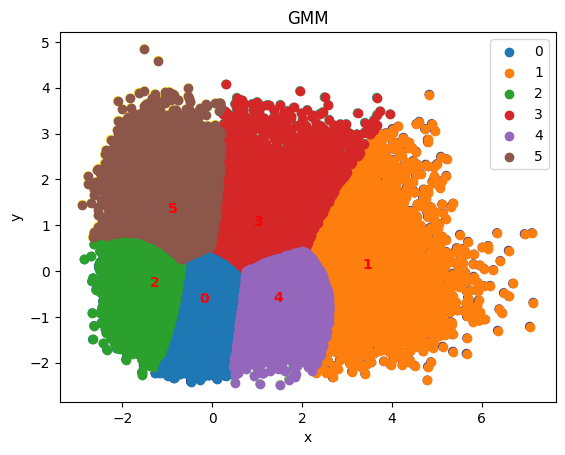

In [7]:
#=========================#
df_gmm = df[['danceability', 'energy', 'loudness', 'acousticness', 'tempo']]
#=========================#
n = 6
#=========================#

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_gmm)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

gmm = GaussianMixture(n_components=n, random_state=42)
gmm.fit(df_pca)

df_gmm['pca_x'] = df_pca[:, 0]
df_gmm['pca_y'] = df_pca[:, 1]
df_gmm['GMM_cluster'] = gmm.predict(df_pca)

plt.scatter(df_pca[:, 0], df_pca[:, 1], c=gmm.predict(df_pca), cmap='viridis')
    
cluster_counts = df_gmm['GMM_cluster'].value_counts()
print(cluster_counts)

# 마커 클러스터 표시
for cluster in range(n):
    cluster_points = df_gmm[df_gmm['GMM_cluster'] == cluster]
    plt.scatter(cluster_points['pca_x'], cluster_points['pca_y'], label=str(cluster), cmap='viridis')
    centroid = gmm.means_[cluster]
    plt.annotate(str(cluster), (centroid[0], centroid[1]), fontsize=10, fontweight='bold', color='red')

score = silhouette_score(df_scaled, gmm.predict(df_pca))
print(score)
plt.title('GMM')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 특정 음원과 코사인 유사도가 높은 곡 추출하기

In [91]:
# 기존 데이터에 군집 추가

gmm_cluster = df_gmm[['GMM_cluster', 'pca_x', 'pca_y']]
df_cluster = pd.merge(gmm_cluster, df, left_index=True, right_index=True)
df_cluster = df_cluster.reset_index(drop=True)
df_cluster

,GMM_cluster,pca_x,pca_y,danceability,energy,music_key,loudness,music_mode,speechiness,acousticness,insrumentalness,liveness,valence,tempo,duration_ms,time_signature,TRACK_ID
0,0,-0.321095,0.399344,0.620,0.586,1,-6.612,1,0.2120,0.1550,0.000000,0.5350,0.487,137.131,130980,4,000TJlEJQ3nafsm1hBWpoj
1,2,-0.905443,0.323567,0.579,0.761,0,-5.550,1,0.0516,0.0975,0.001820,0.2730,0.286,126.163,148095,4,001op3H5t7sehq5JCG2PvM
2,0,0.110342,0.382779,0.585,0.683,8,-3.827,1,0.0523,0.7370,0.000000,0.1140,0.493,128.018,157987,3,002wiS64p2qXaYYVAP7KOW
3,0,-0.158861,0.008299,0.557,0.845,5,-9.292,0,0.0466,0.2690,0.859000,0.1300,0.799,111.562,128090,4,003DYiYPxYSgbtRTXzkcf6
4,4,1.940061,-0.025307,0.611,0.399,11,-11.474,0,0.0357,0.7220,0.000164,0.2590,0.310,122.880,296267,3,003iZmWziYecRnqwchpdQf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56890,0,-0.201132,-0.970661,0.651,0.720,9,-6.529,1,0.1610,0.3310,0.413000,0.5280,0.705,90.024,269245,4,7zy7iE31dGO70ShMXghsfj
56891,0,-0.774289,-1.346438,0.780,0.858,7,-6.331,0,0.1280,0.3570,0.000000,0.0937,0.500,93.984,291002,4,7zyEA6ntsqPH7sLc1YYK26
56892,5,-1.338679,2.228623,0.482,0.865,2,-4.930,1,0.1710,0.1100,0.000000,0.0903,0.822,179.792,182350,4,7zyzK3nsLKF5uTPmHW4PqO
56893,3,0.972144,0.382452,0.549,0.590,0,-7.498,0,0.0293,0.7360,0.000188,0.1490,0.485,124.991,268894,4,7zzPS1pWJShggLI763s9jb


In [92]:
# 예시 음원
df_sample = df_gmm[['GMM_cluster', 'pca_x', 'pca_y']].sample(1)
df_sample = pd.merge(df_sample, df, left_index=True, right_index=True)
df_sample

,GMM_cluster,pca_x,pca_y,danceability,energy,music_key,loudness,music_mode,speechiness,acousticness,insrumentalness,liveness,valence,tempo,duration_ms,time_signature,TRACK_ID
32276,4,1.669336,-1.080822,0.627,0.428,3,-9.823,1,0.0301,0.664,0.0,0.112,0.397,86.001,210384,4,4OmI0k8g7OM7VKPSCyJTJ5


In [93]:
# 예시 음원의 군집

sample_cluster = df_sample['GMM_cluster'].values[0]
sample_cluster

4

In [94]:
# 예시 음원과 같은 군집 내의 음원

df_same_cluster = df_cluster[df_cluster['GMM_cluster'] == sample_cluster]
df_same_cluster.sample(10)

,GMM_cluster,pca_x,pca_y,danceability,energy,music_key,loudness,music_mode,speechiness,acousticness,insrumentalness,liveness,valence,tempo,duration_ms,time_signature,TRACK_ID
15002,4,0.773288,-0.561811,0.552,0.546,2,-7.548,1,0.0334,0.4600,0.000001,0.0701,0.263,92.092,334013,4,21N2jEAO4O9v4OLMGVhgXb
22281,4,2.033083,0.009604,0.469,0.315,8,-7.412,1,0.0349,0.8100,0.000000,0.1140,0.358,102.157,219977,4,326Di9nEnC8tzxxtBsjOUv
9406,4,2.140531,-0.701835,0.440,0.274,5,-14.464,0,0.0809,0.0924,0.000003,0.1280,0.343,76.513,257180,4,1GZJGEId948OqKmf24ubj5
15071,4,2.328447,-0.950047,0.796,0.298,1,-11.185,1,0.1310,0.9880,0.000210,0.1320,0.852,117.121,142002,4,224dHbg9mCkat4NoSnX0vk
42311,4,2.116939,-0.575486,0.381,0.373,9,-7.687,1,0.0294,0.7380,0.000650,0.0989,0.151,67.377,266933,4,5mwewbv8nbk1rC6s8MowP1
11012,4,2.360929,-1.009984,0.625,0.394,0,-17.667,1,0.1690,0.3450,0.000000,0.5220,0.712,92.263,221253,4,1U8nY4b2kw4W9O4UUWIS33
48696,4,1.890906,-0.813059,0.547,0.399,10,-9.808,1,0.0246,0.6680,0.000003,0.1320,0.563,84.127,174707,4,6g6ocTbfC5dKCWKtTi1knS
33547,4,0.726317,-1.089174,0.716,0.695,8,-11.146,1,0.0449,0.5140,0.916000,0.0933,0.693,96.994,250384,4,4Zwo8D1koSzLJCYd5NlX81
31319,4,0.790567,-0.381253,0.762,0.560,9,-9.153,0,0.0450,0.6620,0.000359,0.1840,0.535,129.987,312440,4,4GrRJLBSLhocTkNBaszA02
32996,4,1.498263,-0.721633,0.537,0.495,9,-9.416,1,0.0573,0.6090,0.000002,0.1120,0.492,84.948,267389,4,4UwqOWDpdeIDVQDuKT6iza


In [132]:
# 군집화에 사용된 컬럼들의 벡터값 추출

df_sample_vector = df_sample[['danceability', 'energy', 'loudness', 'acousticness', 'tempo']].values # 유저가 선택한 음원
df_same_cluster_vector = df_same_cluster[['danceability', 'energy', 'loudness', 'acousticness', 'tempo']].values # 같은 군집 내 음원들

In [134]:
# 예시음원과 같은 군집내에서 코사인 유사도가 높은 n곡 추출

cosine_similarities = cosine_similarity(df_sample_vector, df_same_cluster_vector)
similar1 = np.argsort(cosine_similarities, axis=1)[:, ::-1]
similar2 = similar1.flatten()
top = df_same_cluster.iloc[similar2]
top['similarity'] = cosine_similarities.flatten()[similar2]

# 예시 음원 중복 제거
top = top.drop(index=df_sample.index.tolist()[0])

top['rank'] = np.arange(1, len(top)+1)

C:\Users\rnlay\AppData\Local\Temp\ipykernel_22292\3024543597.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top['similarity'] = cosine_similarities.flatten()[similar2]


In [140]:
top10 = top[0:9]
top10

,GMM_cluster,pca_x,pca_y,danceability,energy,music_key,loudness,music_mode,speechiness,acousticness,insrumentalness,liveness,valence,tempo,duration_ms,time_signature,TRACK_ID,similarity,rank
53688,4,1.520948,-1.106607,0.606,0.416,8,-9.399,0,0.0645,0.565,0.000001,0.0876,0.684,82.109,110000,3,7M45t3EEd8YECUo5LhMEEW,1.000000,1
40006,4,1.603064,-1.373401,0.678,0.404,0,-9.550,1,0.0270,0.655,0.000000,0.2490,0.353,83.104,240723,3,5ShenzydHxkHm8w6vdJxMT,0.999999,2
13864,4,1.601698,-1.369917,0.677,0.404,0,-9.552,1,0.0270,0.653,0.000000,0.2490,0.355,83.087,240723,3,1rnYNAJPAb586NhetosdNW,0.999999,3
25757,4,1.860900,-0.985920,0.555,0.377,1,-9.123,1,0.0295,0.671,0.000000,0.1280,0.619,78.985,158253,4,3VYPgMh0510jQ8oSPLz5jF,0.999999,4
49958,4,1.999871,-1.094264,0.750,0.373,0,-12.031,1,0.0285,0.755,0.022000,0.1170,0.610,105.045,223067,4,6qkoo6SQru2khgh87tarNT,0.999999,5
25458,4,1.678511,-0.728750,0.590,0.552,1,-10.481,1,0.0382,0.778,0.912000,0.0811,0.707,92.032,215743,4,3Swq1Ex1Z3bIscToas4maG,0.999999,6
36624,4,1.417855,-0.909233,0.509,0.471,0,-8.491,1,0.0291,0.549,0.000000,0.1260,0.261,73.970,254489,4,4zosO84z2K8csJrWFjf34H,0.999999,7
12642,4,1.417855,-0.909233,0.509,0.471,0,-8.491,1,0.0291,0.549,0.000000,0.1260,0.261,73.970,254489,4,1hp6XGO7kEyHhswy8ivk5y,0.999999,8
27616,4,2.165903,-0.570356,0.626,0.424,5,-11.986,1,0.0250,0.811,0.200000,0.2580,0.327,104.995,293757,4,3kwk52VNXhtofbOQ38mmCg,0.999999,9


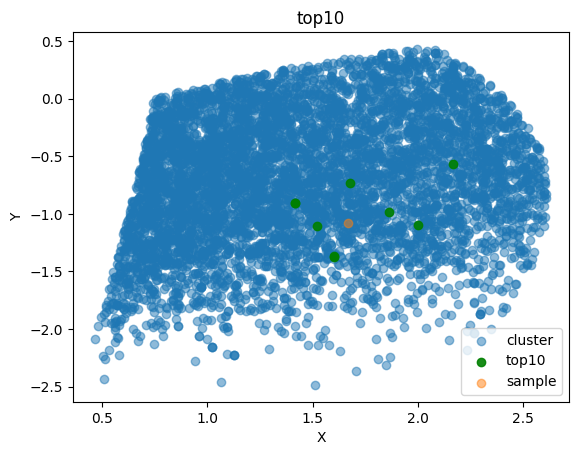

In [141]:
# 해당 군집 그래프

plt.scatter(df_same_cluster['pca_x'], df_same_cluster['pca_y'], label='cluster', alpha=0.5)
plt.scatter(top10['pca_x'], top10['pca_y'], label='top10', alpha=0.9, marker='o', color='green')
plt.scatter(df_sample['pca_x'], df_sample['pca_y'], label='sample', alpha=0.5)

plt.legend()
plt.title('top10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()